In [1]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

from multiview.cotraining.ctclassifier import CTClassifier
from multiview.datasets.base import load_UCImultifeature

In [2]:
data, labels = load_UCImultifeature(select_labeled=[0,1])

# Use only the first 2 views as an example
View0, View1 = data[0], data[1]

# Split both views into testing and training
View0_train, View0_test, labels_train_full, labels_test_full = train_test_split(View0, labels, test_size=0.33, random_state=42)
View1_train, View1_test, labels_train_full, labels_test_full = train_test_split(View1, labels, test_size=0.33, random_state=42)



In [6]:
N_labeled_full = []
acc_ct_full = []
acc_v0_full = []
acc_v1_full = []

iters = 500

for i, num in zip(np.linspace(0.03, .30, 20), (np.linspace(4, 30, 20)).astype(int)):
    
    N_labeled = []
    acc_ct = []
    acc_v0 = []
    acc_v1 = []
    
    View0_train, View0_test, labels_train_full, labels_test_full = train_test_split(View0, labels, test_size=0.33, random_state=42)
    View1_train, View1_test, labels_train_full, labels_test_full = train_test_split(View1, labels, test_size=0.33, random_state=42)

    for seed in range(iters):
    
        labels_train = labels_train_full.copy()
        labels_test = labels_test_full.copy()
        
        # Randomly remove all but 4 of the labels
        np.random.seed(2*seed) #6
        remove_idx = np.random.rand(len(labels_train),) < 1-i
        labels_train[remove_idx] = np.nan
        not_removed = np.where(remove_idx==False)[0]
        not_removed = not_removed[:num]
        N_labeled.append(len(labels_train[not_removed])/len(labels_train))
        if len(set(labels_train[not_removed])) != 2:
            continue

        ############## Single view semi-supervised learning ##############
        #-----------------------------------------------------------------
        gnb0 = GaussianNB()
        gnb1 = GaussianNB()

        # Train on only the examples with labels
        gnb0.fit(View0_train[not_removed,:].squeeze(), labels_train[not_removed])

        y_pred0 = gnb0.predict(View0_test)
        gnb1.fit(View1_train[not_removed,:].squeeze(), labels_train[not_removed])
        y_pred1 = gnb1.predict(View1_test)

        acc_v0.append(accuracy_score(labels_test, y_pred0))
        acc_v1.append(accuracy_score(labels_test, y_pred1))

        ######### Multi-view co-training semi-supervised learning #########
        #------------------------------------------------------------------
        # Train a CTClassifier on all the labeled and unlabeled training data
        ctc = CTClassifier()
        ctc.fit([View0_train, View1_train], labels_train)
        y_pred_ct = ctc.predict([View0_test, View1_test])
        acc_ct.append(accuracy_score(labels_test, y_pred_ct))
        
    print(i)
        
    acc_ct_full.append(np.mean(acc_ct))
    acc_v0_full.append(np.mean(acc_v0))
    acc_v1_full.append(np.mean(acc_v1))
    N_labeled_full.append(np.mean(N_labeled))

0.03
0.0442105263158
0.0584210526316
0.0726315789474
0.0868421052632
0.101052631579
0.115263157895
0.129473684211
0.143684210526
0.157894736842
0.172105263158
0.186315789474
0.200526315789
0.214736842105
0.228947368421
0.243157894737
0.257368421053
0.271578947368
0.285789473684
0.3


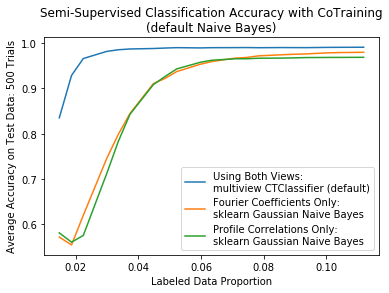

In [7]:


plt.figure()
plt.plot(N_labeled_full, acc_ct_full)
plt.plot(N_labeled_full, acc_v0_full)
plt.plot(N_labeled_full, acc_v1_full)
plt.legend(("Using Both Views:\nmultiview CTClassifier (default)", "Fourier Coefficients Only:\nsklearn Gaussian Naive Bayes", "Profile Correlations Only:\nsklearn Gaussian Naive Bayes"))
plt.title("Semi-Supervised Classification Accuracy with CoTraining\n(default Naive Bayes)")
plt.xlabel("Labeled Data Proportion")
plt.ylabel("Average Accuracy on Test Data: {} Trials".format(iters))
plt.savefig('AvgAccuracy_CTClassifier.png', bbox_inches='tight')
plt.show()


In [62]:
print(not_removed)

(array([  1,   6,   7,  10,  24,  25,  26,  27,  28,  29,  30,  39,  40,
        47,  51,  57,  63,  67,  69,  78,  80,  81,  84,  85,  90,  91,
        92,  95,  96, 100, 102, 104, 110, 116, 117, 126, 127, 129, 131,
       138, 140, 142, 143, 152, 159, 160, 166, 174, 175, 178, 181, 182,
       186, 188, 198, 200, 205, 206, 210, 213, 220, 221, 225, 244, 247,
       249, 257, 258, 260, 266, 267], dtype=int64),)
